In [1]:
import os
import numpy as np
import pandas as pd
from scipy import stats
import h5py

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

import statsmodels.api as sm

from statannotations.Annotator import Annotator
import pyBigWig

In [2]:
# relevant track indices for tissues with matches DNase and CAGE tracks
DNASE = {"Pancreas": 257,
                 "Ovary": 439,
                 "Liver": 452,
                 "Uterus": 283,
                 "Testis": 665,
                 "Spleen": 594,
                 "Lung": 245,
                 "Thyroid": 241,
                 "Prostate": 653,
                 "Vagina": 382,
                 "Stomach": 204,
                 "Adrenal_Gland": 265,
                 "Cells_EBV-transformed_lymphocytes": 69}


CAGE = {"Pancreas": 4946,
              "Ovary": 4688,
              "Liver": 4686,
              "Uterus": 4910,
              "Testis": 4694,
              "Spleen": 4693,
              "Lung": 4687,
              "Thyroid": 4696,
              "Prostate": 4690,
              "Vagina": 5175,
              "Stomach": 4959,
              "Adrenal_Gland": 4977,
              "Cells_EBV-transformed_lymphocytes": 5110}

In [3]:
# human readable descriptions of the matched tracks
track_to_desc = {}

data = pd.read_table("human_targets.txt", sep='\t')
print(data.columns)

for i in set().union(CAGE.values(), DNASE.values()):
    desc = data.loc[data['index'] == i].get('description')
    track_to_desc[i] = desc.values[0]

Index(['index', 'genome', 'identifier', 'file', 'clip', 'scale', 'sum_stat',
       'description'],
      dtype='object')


In [4]:
track_to_desc

{257: 'DNASE:pancreas male adult (34 years)',
 265: 'DNASE:adrenal gland male adult (37 years)',
 653: 'DNASE:prostate gland male adult (37 years)',
 665: 'DNASE:testis male adult (54 years)',
 283: 'DNASE:uterus female adult (53 years)',
 4910: 'CAGE:uterus, adult, pool1',
 439: 'DNASE:ovary female adult (53 years)',
 5175: 'CAGE:vagina, adult',
 452: 'DNASE:liver female embryo (101 day) and female embryo (113 days)',
 69: 'DNASE:GM12878',
 204: 'DNASE:stomach female embryo (107 days)',
 4686: 'CAGE:liver, adult, pool1',
 4687: 'CAGE:lung, adult, pool1',
 4688: 'CAGE:ovary, adult, pool1',
 594: 'DNASE:spleen male adult (54 years)',
 4946: 'CAGE:pancreas, adult,',
 4690: 'CAGE:prostate, adult, pool1',
 4693: 'CAGE:spleen, adult, pool1',
 4694: 'CAGE:testis, adult, pool1',
 4696: 'CAGE:thyroid, adult, pool1',
 4959: 'CAGE:stomach, fetal,',
 4977: 'CAGE:adrenal gland, adult, pool1',
 241: 'DNASE:thyroid gland male adult (37 years)',
 245: 'DNASE:upper lobe of left lung male adult (37 yea

5 basenji2 replicates, 5313 tracks, eQTL set sizes vary by tissue

In [5]:
# template path for where h5 prediction files are stored for each of the 5 replicates
# for example, use as eqtl_preds_path.format(replicate, tissue, variant_set)
EQTL_PREDS_PATH = '/global/scratch/users/poojakathail/enformer/gtex_fine/preds/basenji2_{}_{}_{}_REF_ALT/sad.h5'

# fine-mapped eQTLs stored here as {tissue}.tsv files
SUSIE_RESULTS_PATH = '/global/scratch/users/poojakathail/enformer/gtex_fine/susie'

# single file containing eQTL variant gene pairs
GTEX_GENES_FILE = '/clusterfs/nilah/pooja/genomes/gtex_genes.bed'

# all eQTLs stored here as {tissue}_{variant_set}.vcf files
VCFS_PATH = "/global/scratch/users/poojakathail/enformer/gtex_fine/vcf"

# for calculating phyloP scores
PHYLOP_BIGWIG_FILE = "/clusterfs/nilah/ruchir/data/conservation/241-mammalian-2020v2.bigWig"
PHYLOP_BW = pyBigWig.open(PHYLOP_BIGWIG_FILE)

# (relative) location to save output plots
SAVE_PATH = 'plots'

In [6]:
def get_adjusted_eqtl_sad_preds(tissue):
    
    # count number of eQTLs for this tissue:
    num_eqtls = h5py.File(EQTL_PREDS_PATH.format(1, tissue, 'pos'), 'r')['SAD'].shape[0]
    adjusted_preds = []
    
    for variant_set in ['pos', 'neg']:
        
        preds = np.zeros((5, num_eqtls, 5313))
        multiplier = np.ones_like(preds, dtype=np.float32)

        # can check just replicate 1 to determine sign flip for all replicates
        with h5py.File(EQTL_PREDS_PATH.format(1, tissue, 'pos'), 'r') as f:
            snps = f['snp'][:].astype(str)
            basenji2_refs = f['ref_allele'][:].astype(str)
            basenji2_alts = f['alt_allele'][:].astype(str)

        # Check if any SAD scores need to be flipped because the REF,ALT in VCF referred to 
        # major allele,minor allele as opposed to hg38_ref,hg38_alt.
        # GTEx betas are all in terms of hg38_ref,hg38_alt.
        for i, (snp, basenji2_ref, basenji2_alt) in enumerate(zip(snps, basenji2_refs, basenji2_alts)):
            snp = snp.split("_")
            gtex_ref, gtex_alt = snp[2], snp[3]
            if (basenji2_ref == gtex_alt) and (basenji2_alt == gtex_ref):
                multiplier[:, i, :] *= -1.0

        # Fetch unadjusted SAD scores
        for rep in range(5):
            preds_data = h5py.File(EQTL_PREDS_PATH.format(rep+1, tissue, variant_set), 'r')
            
            hf_ref = np.array(preds_data['REF_sum'])
            hf_alt = np.array(preds_data['ALT_sum'])
            assert(hf_ref.shape == (num_eqtls, 5313))
            assert(hf_alt.shape == (num_eqtls, 5313))

            preds[rep, :, :] = hf_alt - hf_ref ##absolute score
        
        # save multiplier-adjusted SAD scores
        adjusted_preds.append(preds*multiplier)
    
    return adjusted_preds

## Set up dictonaries for tissues, define functions for creating new df columns

In [7]:
# create dict keyed by [tissue][variant_set] to keep track of gtex tissue dfs
df_results_eqtls = {}
num_rows_dfs_pos, num_rows_dfs_neg = {}, {}

# add sign agreement columns for plotting
def frac_agree_label(row):
    label, reps = row['eQTL direction'], row['SAD signs']
    pos_count = sum(1 for i in reps if i > 0)
    if label == True:
        return pos_count / 5
    return (5 - pos_count) / 5

def frac_agree_reps(row):
    reps = row['SAD signs']
    pos_count = sum(1 for i in reps if i > 0)
    return max(pos_count, 5-pos_count) / 5

def add_sign_agreement_columns(df):
    df['fraction sign agreement eQTL direction'] = df.apply(lambda row: frac_agree_label(row), axis=1)
    df['fraction sign agreement among reps'] = df.apply(lambda row: frac_agree_reps(row), axis=1)

    df['num sign agreement eQTL direction'] = (df['fraction sign agreement eQTL direction']*5).astype(int)
    df['num sign agreement among reps'] = (df['fraction sign agreement among reps']*5).astype(int)

    df['(label sign agreement, rep sign agreement)'] = list(zip(df['num sign agreement eQTL direction'],
                                                            df['num sign agreement among reps']))
    
    df['agreement summary'] = df['(label sign agreement, rep sign agreement)']
    df.loc[~df['agreement summary'].isin([(0,5), (5,5)]), 'agreement summary'] = 'noise'
    
    # make values strings
    df['(label sign agreement, rep sign agreement)'] = df['(label sign agreement, rep sign agreement)'].map(str)
    df['agreement summary'] = df['agreement summary'].map(str)
    return

def majority_vote_sign(row):
    signs = row["SAD signs"]
    return np.sign(np.sum(signs))

def rep_1_sign(row):
    signs = row["SAD signs"]
    return signs[0]

bin_size = 128
offset = bin_size / 2
def get_bin_for_tss_distance(tss_distance):
    sign = np.sign(tss_distance)
    abs_tss_distance = np.abs(tss_distance)
    bin_shift = sign * ((abs_tss_distance + offset) // bin_size)
    return 448 + bin_shift

## calculate all new stats as additional df columns (df per tissue and variant set)

In [8]:
#set to CAGE or DNASE depending on your analysis
assay = CAGE
assay_name = ("CAGE" if assay == CAGE else "DNase")
variant_sets = ["pos", "neg"]
filter = True
verbose = False

tlist = list(assay.keys())
tlist.sort() #inplace

for tissue in tlist:
    
    track = assay[tissue]

    pos_preds, neg_preds = get_adjusted_eqtl_sad_preds(tissue)
    pos_sad_track, neg_sad_track = pos_preds[:, :, track], neg_preds[:, :, track]

    susie_results = pd.read_csv(f"{SUSIE_RESULTS_PATH}/{tissue}.tsv",
                                sep="\t",
                                index_col=0)
    gtex_genes = pd.read_csv(GTEX_GENES_FILE,
                            sep="\t", index_col=0)[["name", "chrom", "txStart"]]
    vcfs = {} # a dictonary with 2 dfs for the tissue keyed by [variant_set]
    
    for variant_set in variant_sets:
        if verbose:
            print(f"filter bools set to {filter}")
        vcfs[variant_set] = pd.read_csv(f"{VCFS_PATH}/{tissue}_{variant_set}.vcf",
                                        sep="\t",
                                        skiprows=1, 
                                        names=["chr", "pos", "variant", "ref", "alt", ".", "..", "..."])
        if verbose:
            print(f"original shape of the {variant_set} variant set is {vcfs[variant_set].shape}")

        num_rows = vcfs[variant_set].shape[0]

        if variant_set == "pos":
            sad_track = pos_sad_track
        else:
            sad_track = neg_sad_track
        sad_track = sad_track.transpose((1, 0))
            
        assert(sad_track.shape == (num_rows, 5))
        vcfs[variant_set]["SAD scores"] = sad_track.tolist()
        vcfs[variant_set]["SAD signs"] = np.sign(sad_track).tolist()
        vcfs[variant_set]["SAD magnitudes"] = np.abs(sad_track).tolist()
            
        sad_mean_track = np.mean(sad_track, axis=1)
        assert(num_rows == len(sad_mean_track.tolist()))
        vcfs[variant_set]["SAD mean"] = sad_mean_track.tolist() 

        sad_mag_mean_track = np.mean(np.abs(sad_track), axis=1)
        assert(num_rows == len(sad_mag_mean_track.tolist()))
        vcfs[variant_set]["SAD mean magnitude"] = sad_mag_mean_track.tolist()

        # merging with the SuSIE finemapping results and GTeX gene info to get metadata like TSS distance and eQTL direction
        vcfs[variant_set] = vcfs[variant_set].merge(susie_results, on="variant")
        vcfs[variant_set] = vcfs[variant_set].merge(gtex_genes, left_on="gene", right_on="name")
        
        # create new columns for eQTL direction, effect size, TSS distance
        vcfs[variant_set]["eQTL direction"] = vcfs[variant_set]["beta_marginal"] > 0
        
        vcfs[variant_set]["eQTL effect size"] = vcfs[variant_set]["beta_marginal"]
        vcfs[variant_set]["eQTL effect size magnitude"] = np.abs(vcfs[variant_set]["beta_marginal"])
        
        vcfs[variant_set]["TSS distance"] = (vcfs[variant_set]["txStart"] - vcfs[variant_set]["pos"])
        vcfs[variant_set]["TSS distance magnitude"] = np.abs(vcfs[variant_set]["TSS distance"])
        
        # add majority vote column for sign
        vcfs[variant_set]["SAD sign majority vote"] = vcfs[variant_set].apply(lambda row: majority_vote_sign(row), axis=1)
        
        # add replicate 1 prediction column for sign
        vcfs[variant_set]["SAD sign replicate 1"] = vcfs[variant_set].apply(lambda row: rep_1_sign(row), axis=1)
        
        # add PhyloP scores
        vcfs[variant_set]["phyloP"] = vcfs[variant_set].apply(lambda x: PHYLOP_BW.stats(x.chr, x.pos-1, x.pos)[0], axis=1)
        
        if verbose:
            print(f"after merging with susie results and gtex gene metadata, shape is {vcfs[variant_set].shape}")

        if filter:
            if verbose:
                print(f"filtering on the {variant_set} variant set...")

            # replicating the filtering described in the Enformer methods
            # only keeping variants where the eQTL direction was the same across all genes 
            variant_mask = vcfs[variant_set].groupby('variant')["eQTL direction"].unique().apply(lambda x: len(x))
            variant_mask = variant_mask[variant_mask == 1].index.values
            vcfs[tissue] = vcfs[variant_set][vcfs[variant_set]["variant"].isin(variant_mask)]
            if verbose:
                print(f"after filtering to eQTLS where direction agrees for all genes, shape is {vcfs[variant_set].shape}")

            if variant_set == "pos":
            # filter to only eqtls with pip > 0.9
                vcfs[variant_set] = vcfs[tissue][vcfs[tissue]["pip"] > 0.9]
            else:
                vcfs[variant_set] = vcfs[tissue][vcfs[tissue]["pip"] < 0.01]
            if verbose:
                print(f"after filtering by PIP score, shape is {vcfs[variant_set].shape}")

            # retain closest gene per variant
            vcfs[variant_set] = vcfs[variant_set].loc[vcfs[variant_set].groupby('variant')["TSS distance magnitude"].idxmin()]
            if verbose:
                print(f"after filtering to closest gene per variant, shape is {vcfs[variant_set].shape}")
            
            # only keep eQTLs within Basenji receptive field
            vcfs[variant_set] = vcfs[variant_set][vcfs[variant_set]["TSS distance"].abs() < (896/2 - 1)*128]
            if verbose:
                print(f"after filtering to eQTLS within Basenji receptive field, shape is {vcfs[variant_set].shape}")

        # assign eQTLs to TSS distance bins
        vcfs[variant_set]["TSS bin"] = vcfs[variant_set]["TSS distance"].apply(lambda x: get_bin_for_tss_distance(x))
        if verbose:
            print(f"final shape is {vcfs[variant_set].shape} \n")
        
        if variant_set == "pos":
            # if positive eqtl set, add the sign agreement columns
            add_sign_agreement_columns(vcfs[variant_set])
    
    # record the number of rows of the dfs for this variant set
    num_rows_dfs_pos[tissue] = vcfs["pos"].shape[0]
    num_rows_dfs_neg[tissue] = vcfs["neg"].shape[0]
            
    # record this the vcfs dictonary (with pos and neg sets) in the tissue dictonary
    df_results_eqtls[tissue] = vcfs

In [9]:
# create tlist_sorted_pos, which is sorted by highest number of eqtls to lowest for the positive set

tdict_sorted_pos = {k: v for k, v in sorted(num_rows_dfs_pos.items(), key=lambda item: item[1], reverse=True)}
tlist_sorted_pos = tdict_sorted_pos.keys()

## construct combined pos and neg set dfs that combine the tissue eQTL data

In [10]:
all_tissue_df_list = []

for tissue in tlist_sorted_pos:
    df = df_results_eqtls[tissue]["pos"]
    num_rows = df.shape[0]
        
    # additional columns for tissue and tracks
    df["tissue"] = tissue
    df["DNase track"] = DNASE[tissue]
    df["CAGE track"] = CAGE[tissue]
    all_tissue_df_list.append(df)

In [11]:
all_tissue_df = pd.concat(all_tissue_df_list)
    
# create additional renamed columns for prettier plotting
all_tissue_df["sign agreement"] = all_tissue_df["agreement summary"]
all_tissue_df.loc[all_tissue_df["sign agreement"]=="(5, 5)", "sign agreement"] = "Consistently correct"
all_tissue_df.loc[all_tissue_df["sign agreement"]=="noise", "sign agreement"] = "Inconsistent"
all_tissue_df.loc[all_tissue_df["sign agreement"]=="(0, 5)", "sign agreement"] = "Consistently incorrect"

In [12]:
print(all_tissue_df.shape[0])

# assert that the number of rows is equal to the sum of rows of the individual tissue dfs
summed_rows = np.sum([df.shape[0] for df in all_tissue_df_list])
assert(all_tissue_df.shape[0] == summed_rows)

8545


## replicate correlation boxplots for comparing positive and negative sets

In [13]:
corr_df = pd.DataFrame([])

for _, tissue in enumerate(tlist_sorted_pos):
    pos_rep_preds = df_results_eqtls[tissue]['pos']['SAD scores'].tolist()
    ref_preds = np.vstack(pos_rep_preds).astype(np.float32).transpose()
    pairwise_corrs = np.corrcoef(ref_preds)[np.triu_indices(5, k=1)]
    for i, c in enumerate(pairwise_corrs):
        corr_df = corr_df.append({"Tissue": tissue,
                                  "Variant set": "Positive set (PIP > 0.9)",
                                  "Assay": assay_name,
                                  "Statistic": "SAD",
                                  "Model pair": i,
                                  "SpearmanR between replicates": c}, ignore_index=True)
    
    neg_rep_preds = df_results_eqtls[tissue]['neg']['SAD scores'].tolist()
    ref_preds = np.vstack(neg_rep_preds).astype(np.float32).transpose()
    pairwise_corrs = np.corrcoef(ref_preds)[np.triu_indices(5, k=1)]
    for i, c in enumerate(pairwise_corrs):
        corr_df = corr_df.append({"Tissue": tissue,
                                  "Variant set": "Negative set (PIP < 0.01)",
                                  "Assay": assay_name,
                                  "Statistic": "SAD",
                                  "Model pair": i,
                                  "SpearmanR between replicates": c}, ignore_index=True)

# tissue names format
corr_df.loc[corr_df["Tissue"] == "Cells_EBV-transformed_lymphocytes", "Tissue"] = "Cells (EBV-transformed\nlymphocytes)"
corr_df.loc[corr_df["Tissue"] == "Adrenal_Gland", "Tissue"] = "Adrenal Gland"

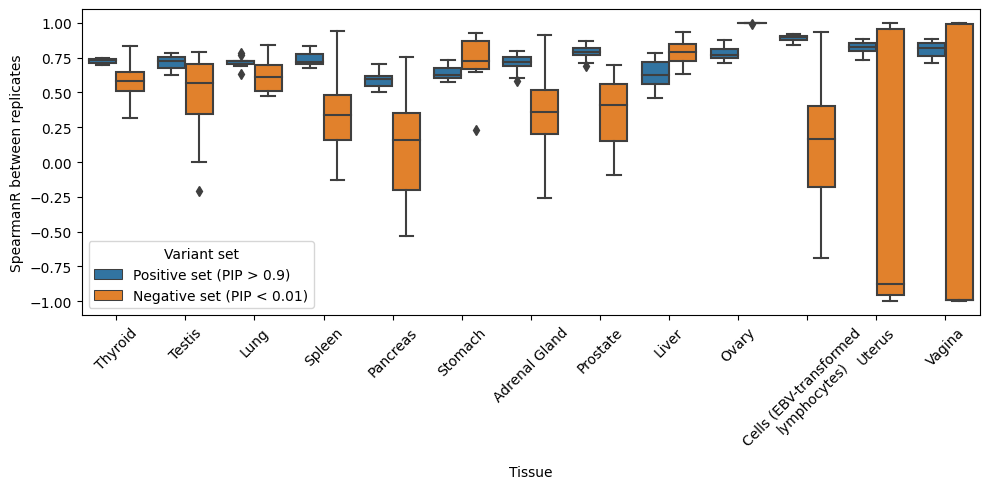

In [14]:
# tissue labels format
labels = list(tlist_sorted_pos).copy()
labels[6] = "Adrenal Gland"
labels[10] = "Cells (EBV-transformed\nlymphocytes)"


for stat in ["SAD"]:
    df_subs = corr_df[(corr_df["Statistic"] == stat) & (corr_df["Assay"] == assay_name)]
    fig, ax = plt.subplots(figsize=(10,5))
    ax = sns.boxplot(data=df_subs,
                     x="Tissue",
                     hue="Variant set",
                     order=labels,
                     y="SpearmanR between replicates",
                     ax=ax)
    #ax.set_title(f"{assay_name}, {stat}")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(
        f"{SAVE_PATH}/{assay_name}_{stat}_pairwise_correlations.pdf", dpi=300)

## sign agreement analysis - between models and versus the eQTL label (sign of recorded effect size)

In [15]:
tissue_heatmaps_sign = {}
tissue_frac_true_positive = {}
tissue_heatmaps_sign_pct = {}

In [16]:
for tissue in tlist_sorted_pos:
    df = df_results_eqtls[tissue]['pos']
    num_rows = df.shape[0]
    
    # create heatmap data
    sign_heatmap_counts = np.zeros((6,6))
    total_sign_counts = np.zeros((6,6))
    pos_sign_counts = np.zeros((6,6))

    for i in df.index.values:
        label_i = df._get_value(i,'num sign agreement eQTL direction')
        reps_i = df._get_value(i,'num sign agreement among reps')
        sign_i = df._get_value(i,'eQTL direction')
        sign_heatmap_counts[reps_i, label_i] += 1
        total_sign_counts[reps_i, label_i] += 1
        if sign_i:
            pos_sign_counts[reps_i, label_i] += 1

    print(sign_heatmap_counts)
    assert(sign_heatmap_counts.sum() == num_rows)

    frac_true_positive = pos_sign_counts / total_sign_counts

    # chop off upper heatmap (empty) rows
    sign_heatmap_counts = sign_heatmap_counts[3:, :]
    frac_true_positive = frac_true_positive[3:, :]
    
    # create percentage heatmap data
    sign_heatmap_pcts = sign_heatmap_counts / num_rows
    assert(sign_heatmap_pcts.sum().round() == 1)

    # save heatmap counts and heatmap percentages to dicts
    tissue_heatmaps_sign[tissue] = sign_heatmap_counts
    tissue_frac_true_positive[tissue] = frac_true_positive
    tissue_heatmaps_sign_pct[tissue] = sign_heatmap_pcts
    

[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0. 213. 272.   0.   0.]
 [  0. 242.   0.   0. 311.   0.]
 [320.   0.   0.   0.   0. 501.]]
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0. 182. 198.   0.   0.]
 [  0. 175.   0.   0. 227.   0.]
 [292.   0.   0.   0.   0. 460.]]
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0. 174. 166.   0.   0.]
 [  0. 174.   0.   0. 198.   0.]
 [180.   0.   0.   0.   0. 336.]]
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.  96. 103.   0.   0.]
 [  0.  92.   0.   0. 107.   0.]
 [104.   0.   0.   0.   0. 246.]]
[[  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.]
 [  0.   0. 103. 110.   0.   0.]
 [  0. 101.   0.   0. 124.   0.]
 [ 97.   0.   0.   0.   0. 188.]]
[[  0

/clusterfs/nilah/ayesha/envs/plotting_py37/lib/python3.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


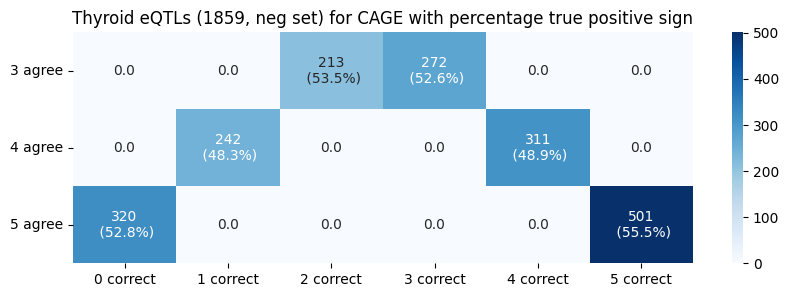

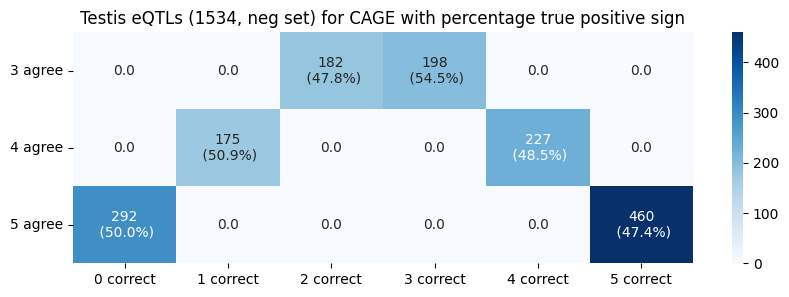

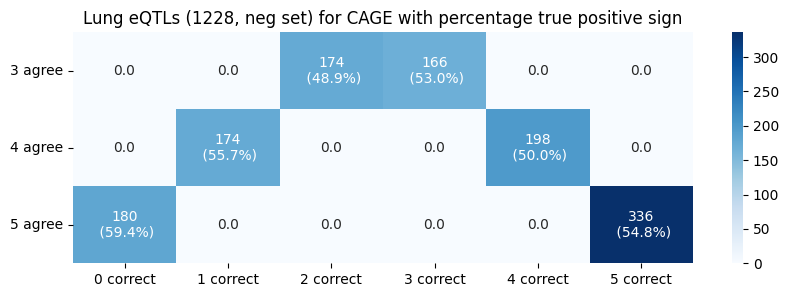

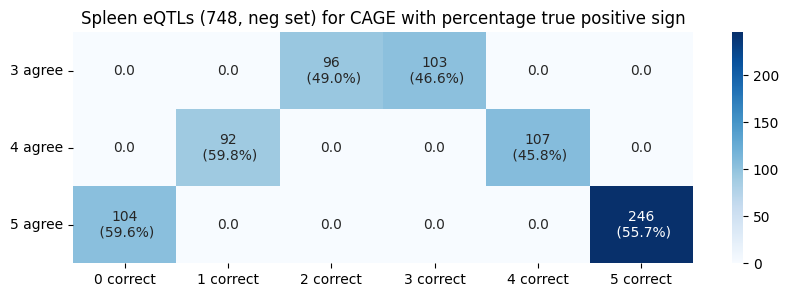

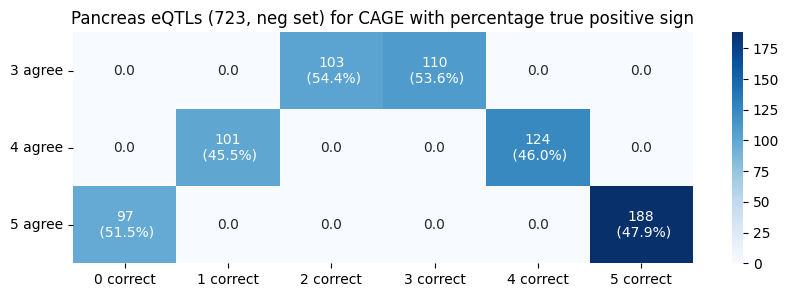

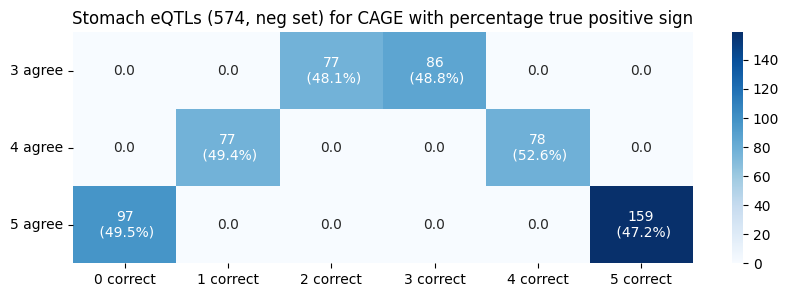

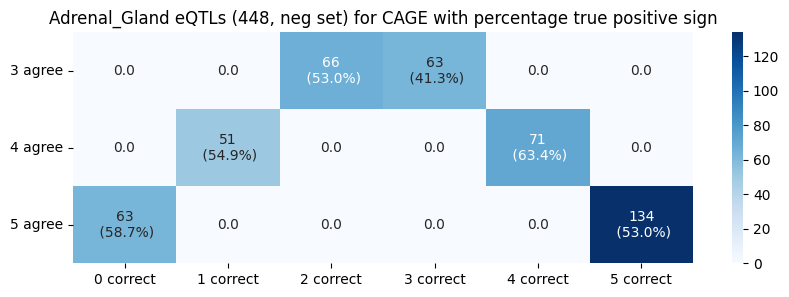

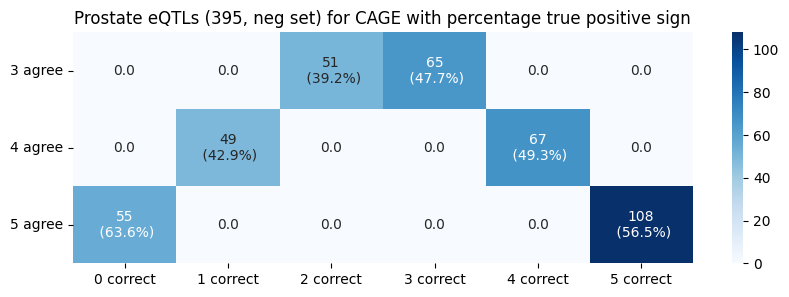

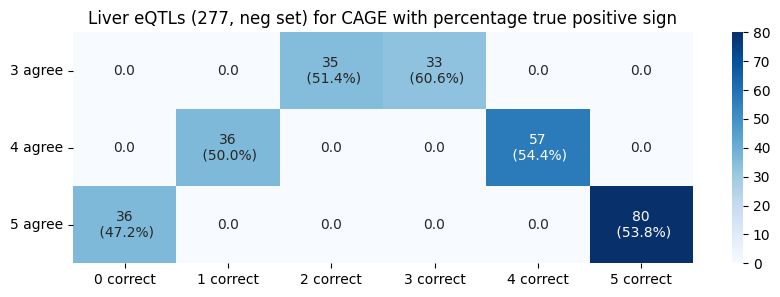

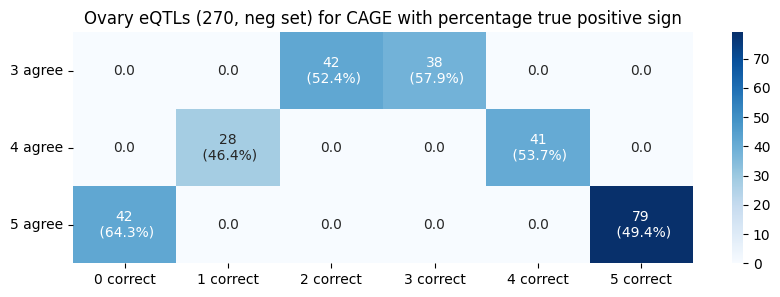

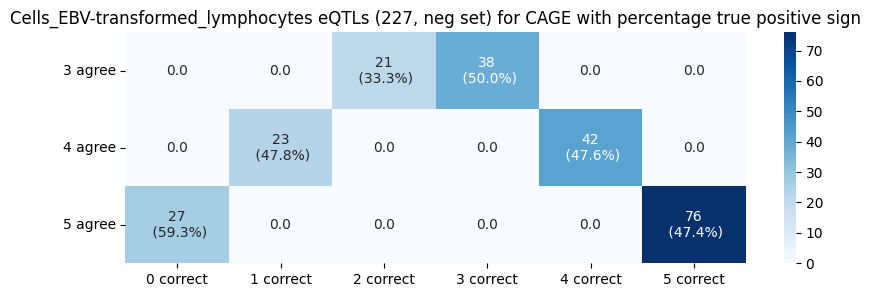

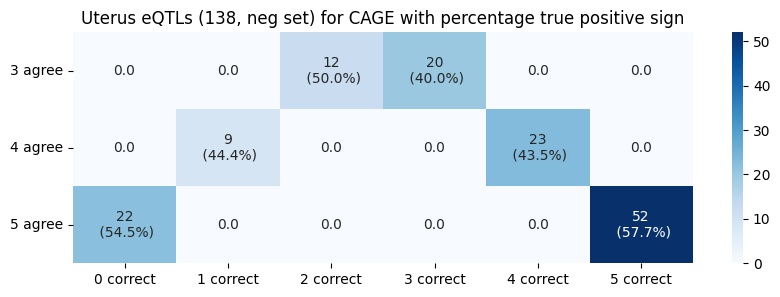

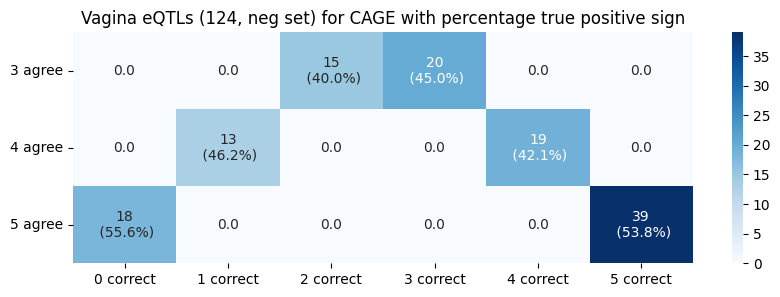

In [17]:
# sign heatmaps
for tissue in tlist_sorted_pos:
    sign_heatmap_counts = tissue_heatmaps_sign[tissue]
    df = df_results_eqtls[tissue]['pos']
    num_rows = df.shape[0]

    plt.figure(figsize=(10,3))

    labels = sign_heatmap_counts.tolist()
    for i in range(len(sign_heatmap_counts)):
        for j in range(len(sign_heatmap_counts[0])):
            if labels[i][j] != 0:
                pct = round(tissue_frac_true_positive[tissue][i,j]*100, 1)
                labels[i][j] = f"{int(sign_heatmap_counts[i,j])}\n ({pct}%)"

    sign_heatmap_df = pd.DataFrame(data = sign_heatmap_counts,
                                   index = ["3 agree", "4 agree", "5 agree"],
                                   columns = [f"{i} correct" for i in range(6)])
                
    sns.heatmap(sign_heatmap_df, annot=np.array(labels), fmt='', cmap='Blues')
    plt.ylim(3, 0)
    plt.yticks(rotation=0)
    plt.title(f"{tissue} eQTLs ({num_rows}, {variant_set} set) for {assay_name} with percentage true positive sign")

    plt.savefig(f'{SAVE_PATH}/{assay_name}/{tissue}_{num_rows}_heatmap_counts.pdf')

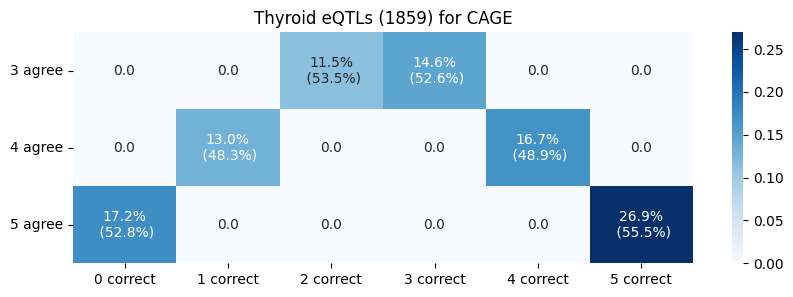

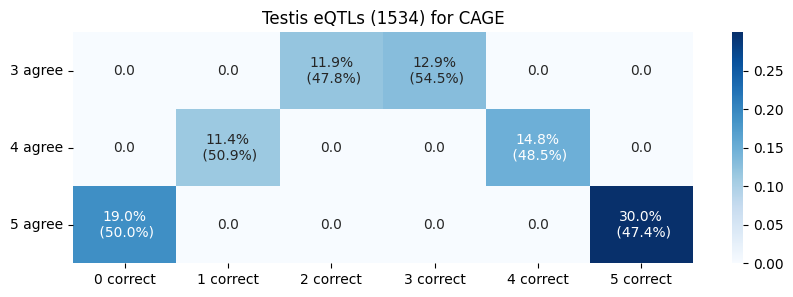

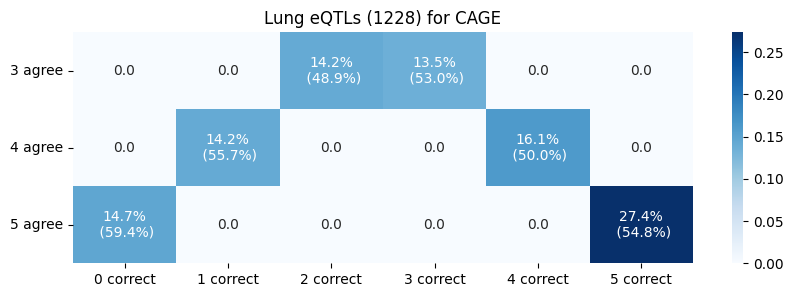

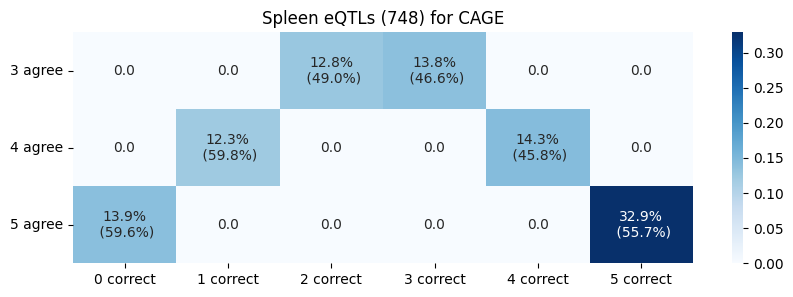

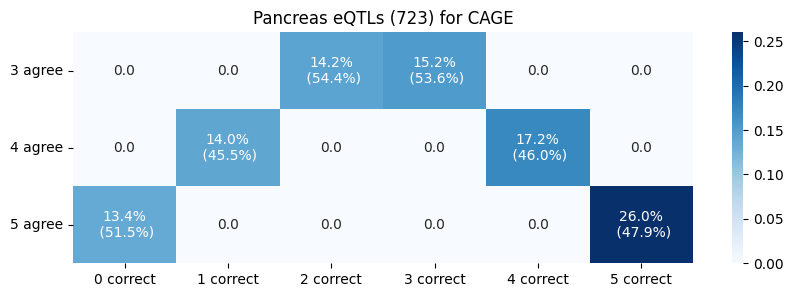

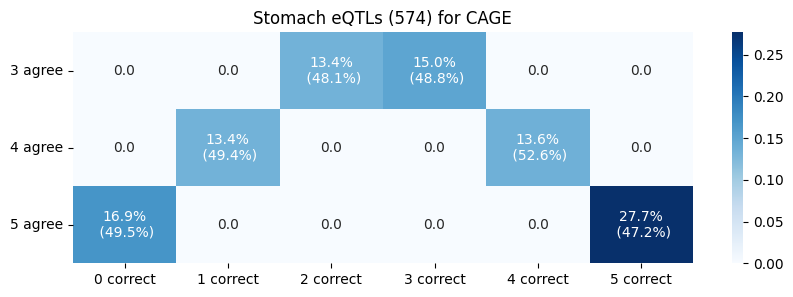

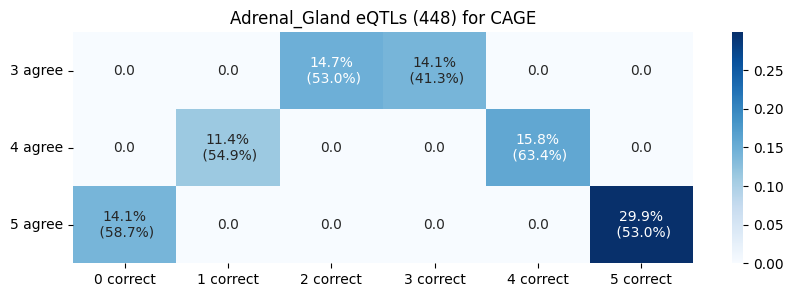

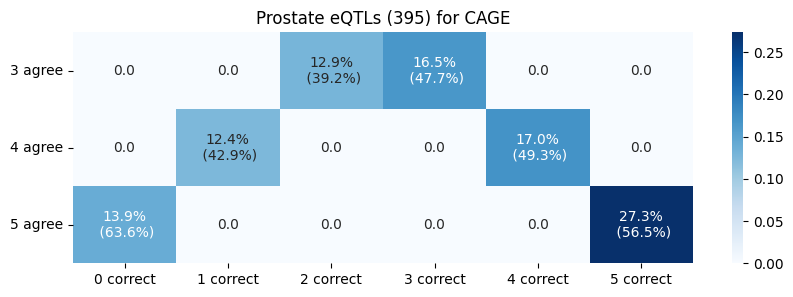

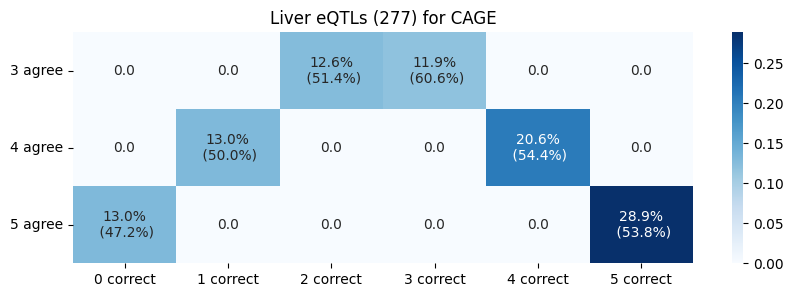

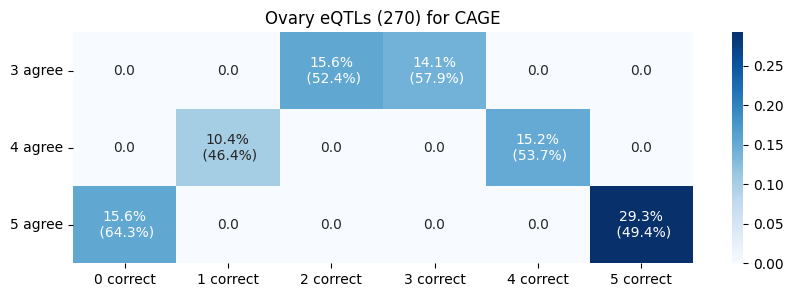

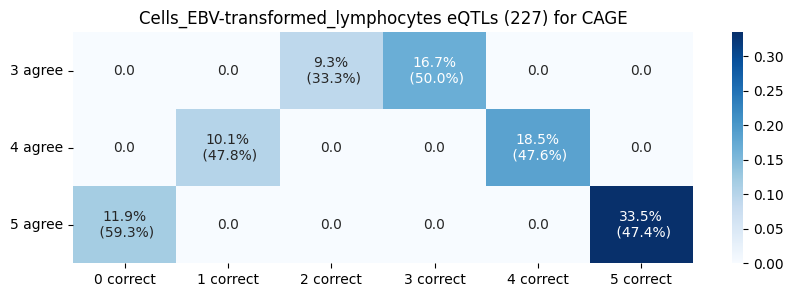

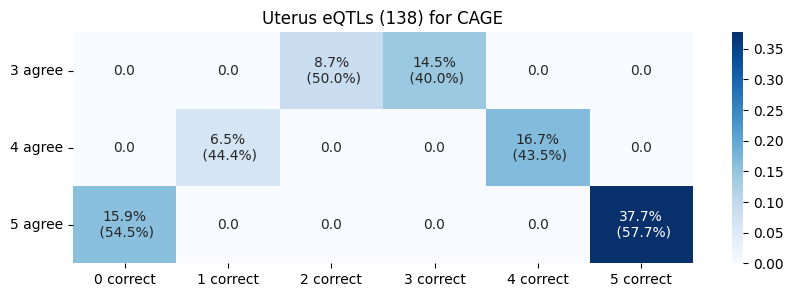

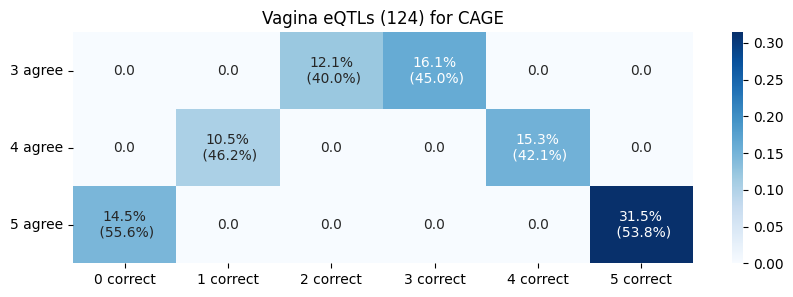

In [18]:
# percentage heatmaps
for tissue in tlist_sorted_pos:
    sign_heatmap_pcts = tissue_heatmaps_sign_pct[tissue]
    df = df_results_eqtls[tissue]['pos']
    num_rows = df.shape[0]

    plt.figure(figsize=(10,3))

    labels = sign_heatmap_pcts.tolist()
    for i in range(len(sign_heatmap_pcts)):
        for j in range(len(sign_heatmap_pcts[0])):
            if labels[i][j] != 0:
                pct = round(tissue_frac_true_positive[tissue][i,j]*100, 1)
                labels[i][j] = f"{round(sign_heatmap_pcts[i,j]*100, 1)}%\n ({pct}%)"

    sign_heatmap_df_pcts = pd.DataFrame(data = sign_heatmap_pcts,
                              index = ["3 agree", "4 agree", "5 agree"],
                              columns = [f"{i} correct" for i in range(6)])

    sns.heatmap(sign_heatmap_df_pcts, annot=np.array(labels), fmt="", cmap='Blues')
    plt.ylim(3, 0)
    plt.yticks(rotation=0)
    plt.title(f"{tissue} eQTLs ({num_rows}) for {assay_name}")
    #plt.title(f"{tissue} eQTLs ({num_rows}, {variant_set} set) for {assay_name} with percentage true positive sign")

    plt.savefig(f'{SAVE_PATH}/{assay_name}/{tissue}_{num_rows}_heatmap_percentage.pdf')

## create combined bar plot to represent the heatmap data across all tissues

In [19]:
group_labels = tlist_sorted_pos
con_incorr, con_corr, noise = [], [], []
noise3, noise4 = [], []
corr1, corr2, corr3, corr4 = [], [], [], []
true_pos = []

for tissue in tlist_sorted_pos:
    sign_heatmap_pcts = tissue_heatmaps_sign_pct[tissue]
    frac_true_positive = tissue_frac_true_positive[tissue]
    sign_heatmap_counts = tissue_heatmaps_sign[tissue]

    con_incorr.append(sign_heatmap_pcts[2,0]) #bottom left
    con_corr.append(sign_heatmap_pcts[2,5]) #bottom right
    noise.append(1-(sign_heatmap_pcts[2,0] + sign_heatmap_pcts[2,5]))
    
    noise4.append(sign_heatmap_pcts[1,1]+sign_heatmap_pcts[1,4])
    noise3.append(sign_heatmap_pcts[0,2]+sign_heatmap_pcts[0,3])
    
    corr1.append(sign_heatmap_pcts[1,1])
    corr2.append(sign_heatmap_pcts[0,2])
    corr3.append(sign_heatmap_pcts[0,3])
    corr4.append(sign_heatmap_pcts[1,4])
    
    true_pos.append(np.nansum(np.multiply(frac_true_positive, sign_heatmap_counts))/np.sum(sign_heatmap_counts))
    
# sanity checks
for i in range(len(tlist_sorted_pos)):
    assert(con_corr[i]+con_incorr[i]+noise[i] == 1)
    assert((con_corr[i]+con_incorr[i]+noise3[i]+noise4[i]).round() == 1)
    
print('\n\n')    
print(con_corr)
print(con_incorr)
print(noise)

print('\n\n')   
print('split noisy')
print(noise3)
print(noise4)

print('\n\n')  
print('num correct')
print(corr1)
print(corr2)
print(corr3)
print(corr4)

print('\n\n') 
for i in range(len(tlist)):
    print(noise[i])
    print(noise3[i]+noise4[i])
    print('\n') 
    
print(true_pos)




[0.2694997310381926, 0.29986962190352023, 0.2736156351791531, 0.32887700534759357, 0.2600276625172891, 0.2770034843205575, 0.29910714285714285, 0.27341772151898736, 0.2888086642599278, 0.29259259259259257, 0.33480176211453744, 0.37681159420289856, 0.31451612903225806]
[0.17213555675094136, 0.19035202086049544, 0.1465798045602606, 0.13903743315508021, 0.13416320885200553, 0.16898954703832753, 0.140625, 0.13924050632911392, 0.1299638989169675, 0.15555555555555556, 0.11894273127753303, 0.15942028985507245, 0.14516129032258066]
[0.558364712210866, 0.5097783572359843, 0.5798045602605864, 0.5320855614973262, 0.6058091286307054, 0.554006968641115, 0.5602678571428572, 0.5873417721518988, 0.5812274368231047, 0.5518518518518518, 0.5462555066079295, 0.46376811594202905, 0.5403225806451613]



split noisy
[0.2608929532006455, 0.24771838331160367, 0.2768729641693811, 0.2660427807486631, 0.29460580912863066, 0.28397212543554007, 0.2879464285714286, 0.2936708860759494, 0.24548736462093862, 0.29629

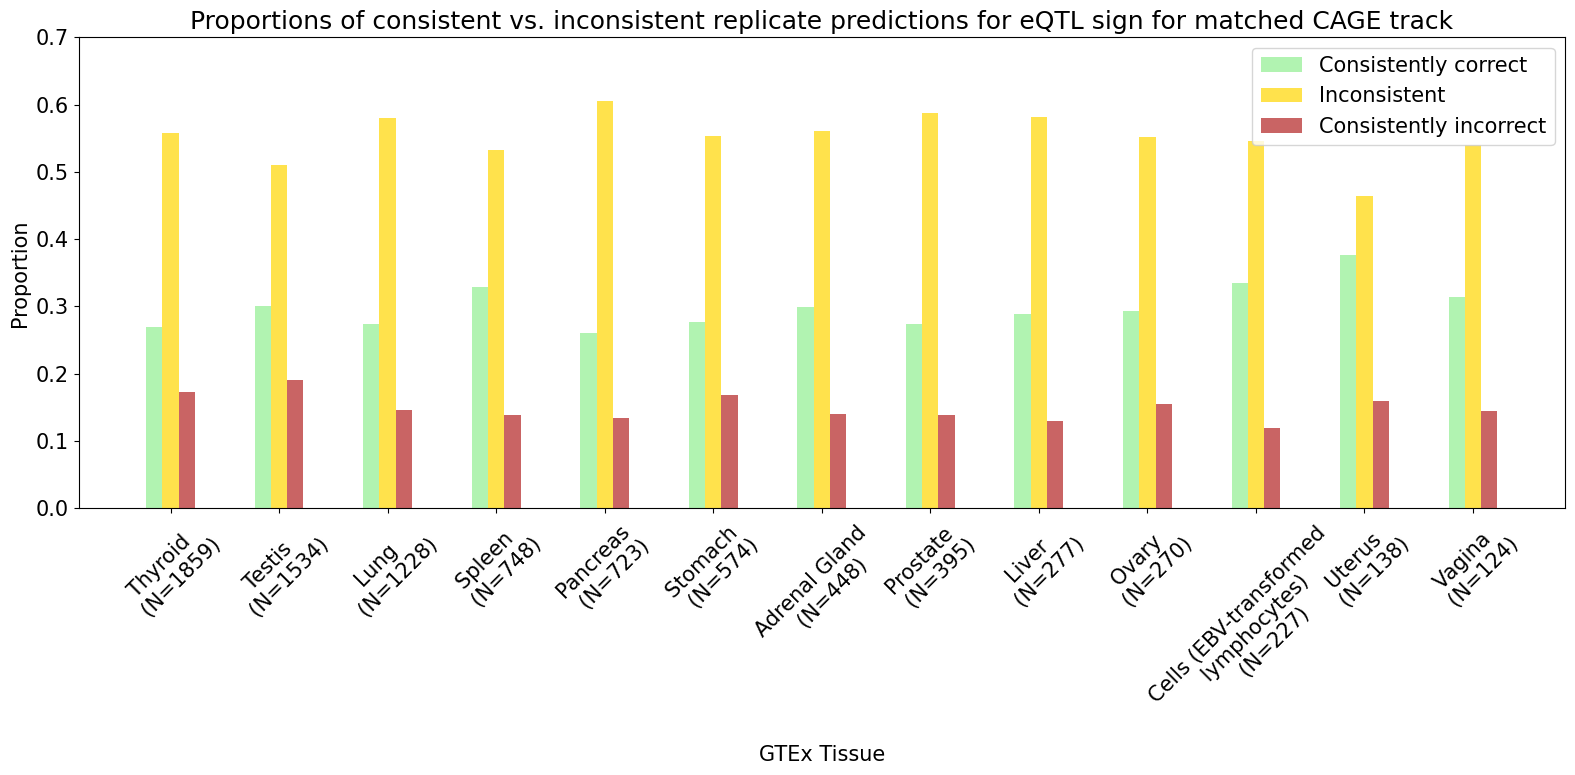

In [20]:
## Not separating 3 vs. 4 rep agreement

# Define the width of each bar group and the width of each bar within a group
bar_width = 0.15
plt.rcParams.update({'font.size': 15})
index = np.arange(len(tlist_sorted_pos))

# edit tissue names format
labels = list(tlist_sorted_pos).copy()
labels[6] = "Adrenal Gland"
labels[10] = "Cells (EBV-transformed \n lymphocytes)"
for i, tissue in enumerate(tlist_sorted_pos):
    labels[i] = f"{labels[i]} \n (N={num_rows_dfs_pos[tissue]})"

fig, ax = plt.subplots(figsize=(16,8))

bar1 = ax.bar(index - bar_width, con_corr, bar_width, label='Consistently correct', color='lightgreen', alpha=0.7)
bar2 = ax.bar(index, noise, bar_width, label='Inconsistent', color='gold', alpha=0.7)
bar3 = ax.bar(index + bar_width, con_incorr, bar_width, label='Consistently incorrect', color='firebrick', alpha=0.7)

ax.set_xlabel('GTEx Tissue')
ax.set_ylabel('Proportion')
ax.set_title(f'Proportions of consistent vs. inconsistent replicate predictions for eQTL sign for matched {assay_name} track')
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation = 45)
ax.legend(loc='upper right')

plt.ylim((0,0.7))
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/{assay_name}/aggreate_{assay_name}_noisy_proportion_eqtls_sign.pdf')

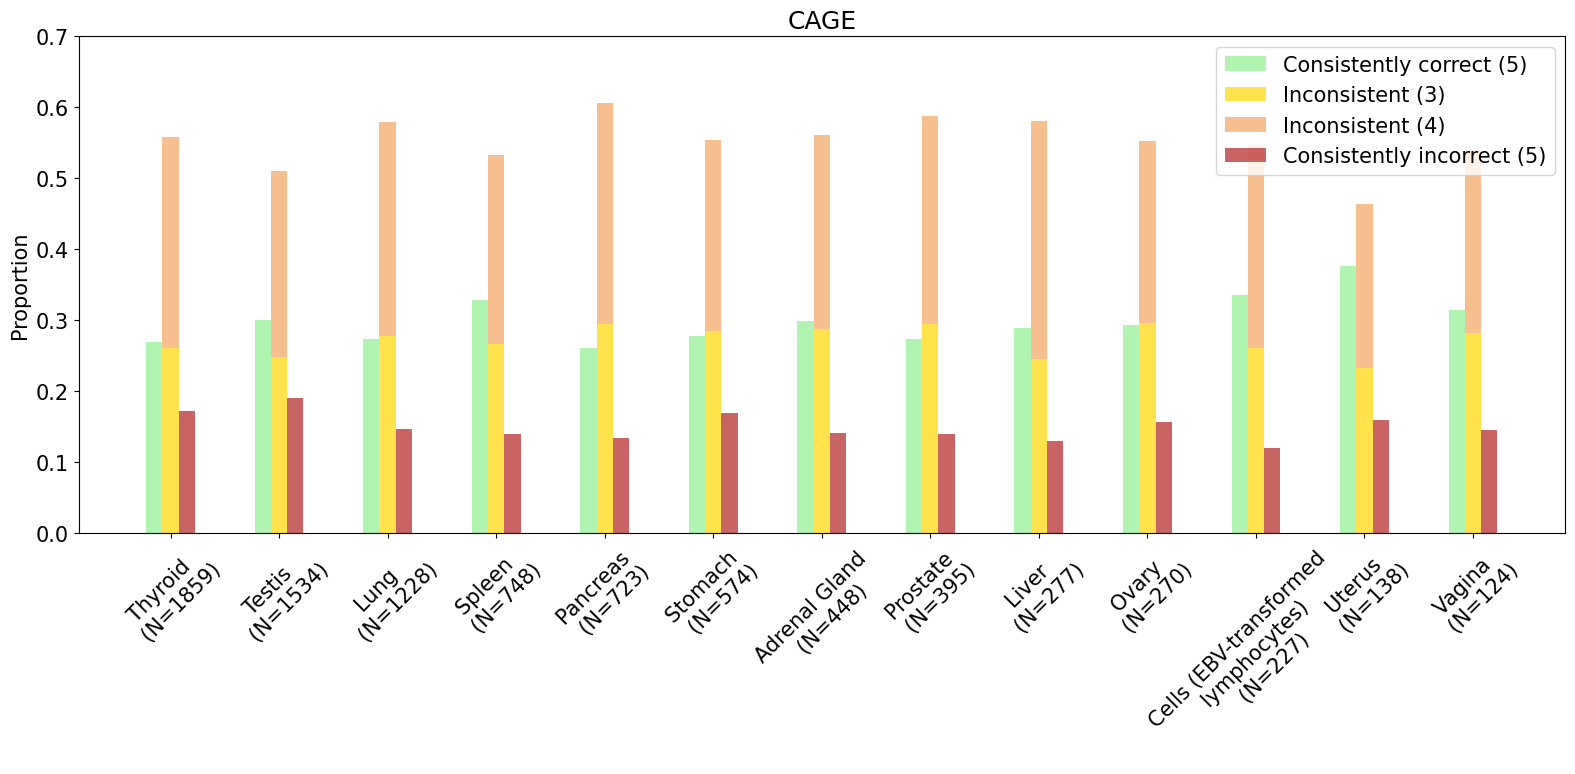

In [21]:
## With separating 3 vs. 4 rep agreement

# Define the width of each bar group and the width of each bar within a group
bar_width = 0.15
plt.rcParams.update({'font.size': 15})
index = np.arange(len(tlist_sorted_pos))

# edit tissue names format
labels = list(tlist_sorted_pos).copy()
labels[6] = "Adrenal Gland"
labels[10] = "Cells (EBV-transformed \n lymphocytes)"
for i, tissue in enumerate(tlist_sorted_pos):
    labels[i] = f"{labels[i]} \n (N={num_rows_dfs_pos[tissue]})"

fig, ax = plt.subplots(figsize=(16,8))

bar1 = ax.bar(index - bar_width, con_corr, bar_width, label='Consistently correct (5)', color='lightgreen', alpha=0.7)
bar2 = ax.bar(index, noise3, bar_width, label='Inconsistent (3)', color='gold', alpha=0.7)
bar22 = ax.bar(index, noise4, bar_width, bottom=noise3, label='Inconsistent (4)', color='sandybrown', alpha=0.7)
bar3 = ax.bar(index + bar_width, con_incorr, bar_width, label='Consistently incorrect (5)', color='firebrick', alpha=0.7)

#ax.set_xlabel('GTEx Tissue')
ax.set_ylabel('Proportion')
#ax.set_title(f'Proportions of consistent vs. inconsistent replicate predictions for eQTL sign for matched {assay_name} track')
ax.set_title(f'{assay_name}')
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation = 45)
ax.legend(loc='upper right')

plt.ylim((0,0.7))
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/{assay_name}/aggreate_{assay_name}_stacked_noisy_proportion_eqtls_sign.pdf')

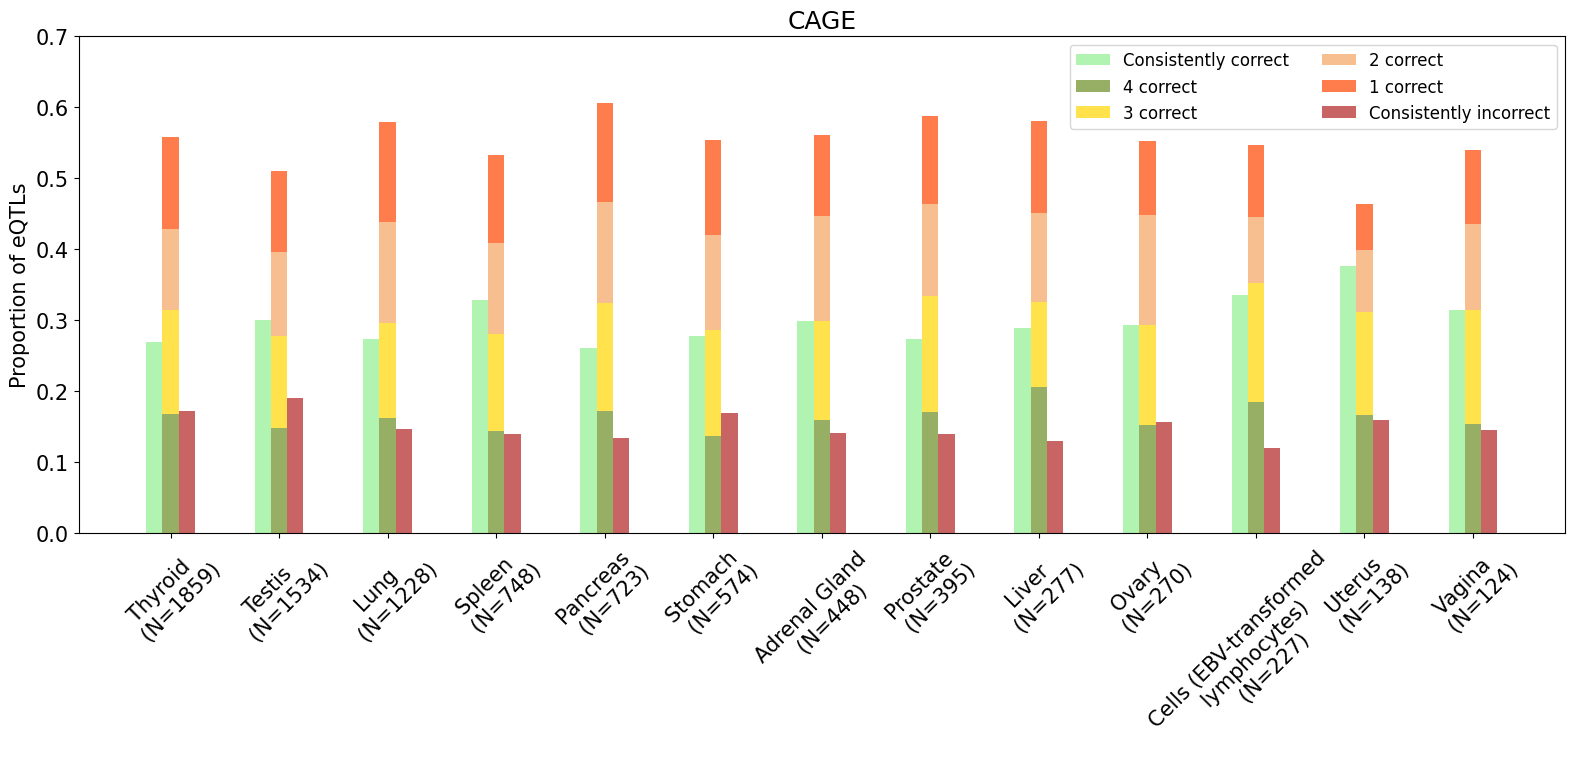

In [22]:
## With separating by num agreement with label

# Define the width of each bar group and the width of each bar within a group
bar_width = 0.15
plt.rcParams.update({'font.size': 15})
index = np.arange(len(tlist_sorted_pos))

# edit tissue names format
labels = list(tlist_sorted_pos).copy()
labels[6] = "Adrenal Gland"
labels[10] = "Cells (EBV-transformed \n lymphocytes)"
for i, tissue in enumerate(tlist_sorted_pos):
    labels[i] = f"{labels[i]} \n (N={num_rows_dfs_pos[tissue]})"

fig, ax = plt.subplots(figsize=(16,8))

bar_cc = ax.bar(index - bar_width, con_corr, bar_width, label='Consistently correct', color='lightgreen', alpha=0.7)
bar_c4 = ax.bar(index, corr4, bar_width, label='4 correct', color='olivedrab', alpha=0.7)
bar_c3 = ax.bar(index, corr3, bar_width, bottom=corr4, label='3 correct', color='gold', alpha=0.7)
b3 = [sum(x) for x in zip(corr4, corr3)]
bar_c2 = ax.bar(index, corr2, bar_width, bottom=b3, label='2 correct', color='sandybrown', alpha=0.7)
b2 = [sum(x) for x in zip(b3, corr2)]
bar_c1 = ax.bar(index, corr1, bar_width, bottom=b2, label='1 correct', color='orangered', alpha=0.7)
bar_ci = ax.bar(index + bar_width, con_incorr, bar_width, label='Consistently incorrect', color='firebrick', alpha=0.7)

ax.set_ylabel('Proportion of eQTLs')
ax.set_title(f'{assay_name}', )
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation = 45)
ax.legend(loc='upper right', ncol=2, fontsize=12)

plt.ylim((0,0.7))
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/{assay_name}/aggreate_{assay_name}_stacked_correct_noisy_proportion_eqtls_sign.pdf')

In [23]:
# bar plot data, pooled across all tissues

# con corr, 4 corr, 3 corr, 2 corr, 1 corr, con incorr
proportions_all = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
total_num_eqtls = 0

for i, tissue in enumerate(tlist_sorted_pos):
    n = num_rows_dfs_pos[tissue]
    total_num_eqtls += n
    proportions_current = [con_corr[i]*n, corr4[i]*n, corr3[i]*n, corr2[i]*n, corr1[i]*n, con_incorr[i]*n]
    proportions_all = [sum(x) for x in zip(proportions_all, proportions_current)]

proportions_all = [x/total_num_eqtls for x in proportions_all]

print(proportions_all)

[0.28765359859566997, 0.15974253949678174, 0.14183733177296665, 0.12720889409011119, 0.12521942656524282, 0.1583382094792276]


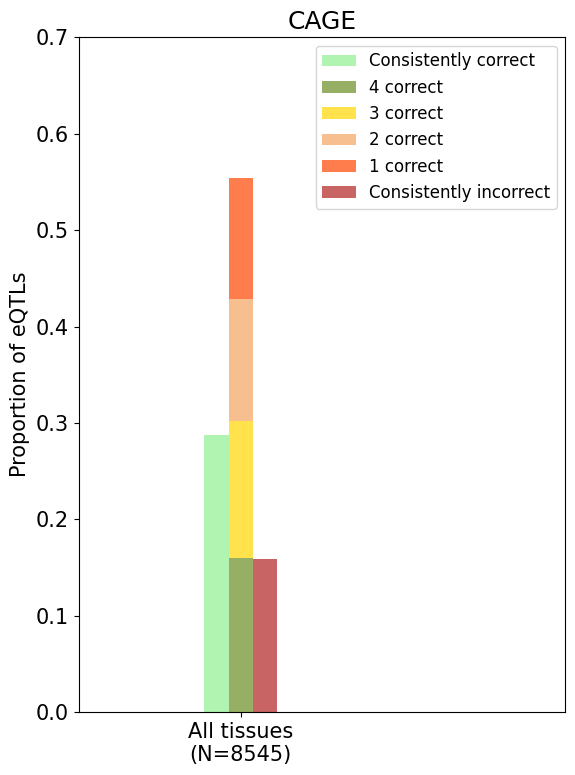

In [24]:
bar_width = 0.15
plt.rcParams.update({'font.size': 15})
index = np.arange(1)

fig, ax = plt.subplots(figsize=(6,8))

bar_cc = ax.bar(index-bar_width, proportions_all[0], bar_width, label='Consistently correct', color='lightgreen', alpha=0.7)
#ax.annotate(f'{round(proportions_all[0], 2)}', xy=(index-bar_width, proportions_all[0]), xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
bar_c4 = ax.bar(index, proportions_all[1], bar_width, label='4 correct', color='olivedrab', alpha=0.7)
bar_c3 = ax.bar(index, proportions_all[2], bar_width, bottom=proportions_all[1], label='3 correct', color='gold', alpha=0.7)
bar_c2 = ax.bar(index, proportions_all[3], bar_width, bottom=sum(proportions_all[1:3]), label='2 correct', color='sandybrown', alpha=0.7)
bar_c1 = ax.bar(index, proportions_all[4], bar_width, bottom=sum(proportions_all[1:4]), label='1 correct', color='orangered', alpha=0.7)
bar_ci = ax.bar(index+bar_width, proportions_all[5], bar_width, label='Consistently incorrect', color='firebrick', alpha=0.7)

ax.set_ylabel('Proportion of eQTLs')
ax.set_title(f'{assay_name}', )
ax.legend(loc='upper right', fontsize=12)

plt.ylim((0,0.7))
plt.xlim((index-1, index+2))

ax.set_xticks([0.0])
ax.set_xticklabels([f'All tissues\n(N={total_num_eqtls})'])

plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/{assay_name}/aggreate_{assay_name}_combined_stacked_correct_noisy_proportion_eqtls_sign.pdf')

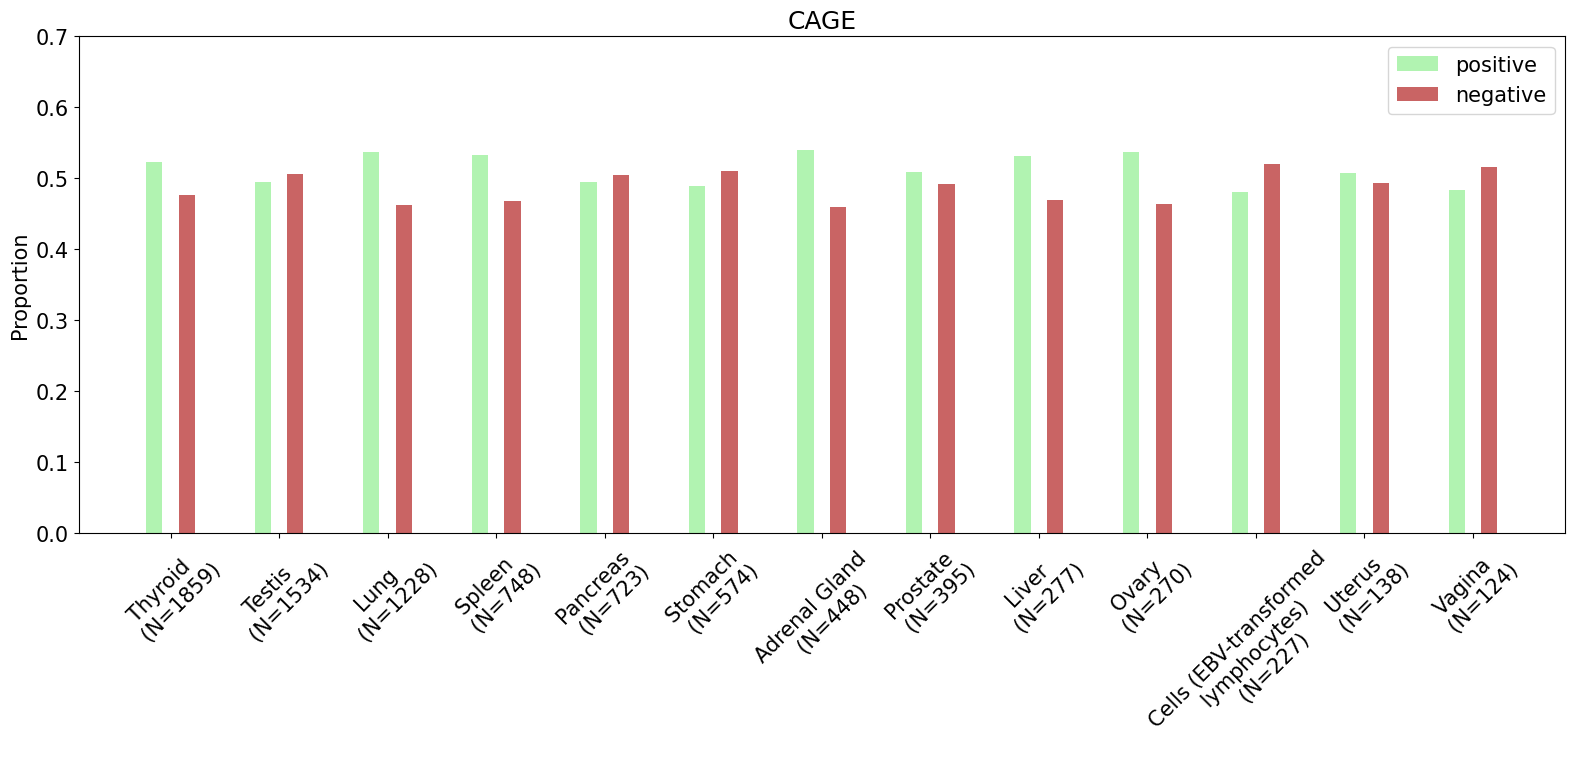

In [25]:
## bar plot of true pos/neg sign to check for label imbalance

# Define the width of each bar group and the width of each bar within a group
bar_width = 0.15
index = np.arange(len(tlist_sorted_pos))

fig, ax = plt.subplots(figsize=(16,8))

bar_pos = ax.bar(index - bar_width, true_pos, bar_width, label='positive', color='lightgreen', alpha=0.7)
bar_neg = ax.bar(index + bar_width, [1-pos for pos in true_pos], bar_width, label='negative', color='firebrick', alpha=0.7)

ax.set_ylabel('Proportion')
ax.set_title(f'{assay_name}')
ax.set_xticks(index)
ax.set_xticklabels(labels, rotation = 45)
ax.legend(loc='upper right')

plt.ylim((0,0.7))
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/{assay_name}/aggreate_{assay_name}_true_positive_frac_eqtls_sign.pdf')

## Consistency vs. other attributes, boxplots with significance

p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Consistently correct vs. Inconsistent: Mann-Whitney-Wilcoxon test two-sided, P_val:9.697e-02 U_stat=5.679e+06
Inconsistent vs. Consistently incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:1.705e-07 U_stat=2.904e+06
Consistently correct vs. Consistently incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:7.805e-09 U_stat=1.475e+06
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Consistently correct vs. Inconsistent: Mann-Whitney-Wilcoxon test two-sided, P_val:2.053e-06 U_stat=6.215e+06
Inconsistent vs. Consistently incorrect: Mann-Whitney-Wilcoxon test two-sided, P_val:5.081e-01 U_stat=3.240e+06
Consistently correct vs. Consistently incorrect: Mann-Whitney-Wilcoxon tes

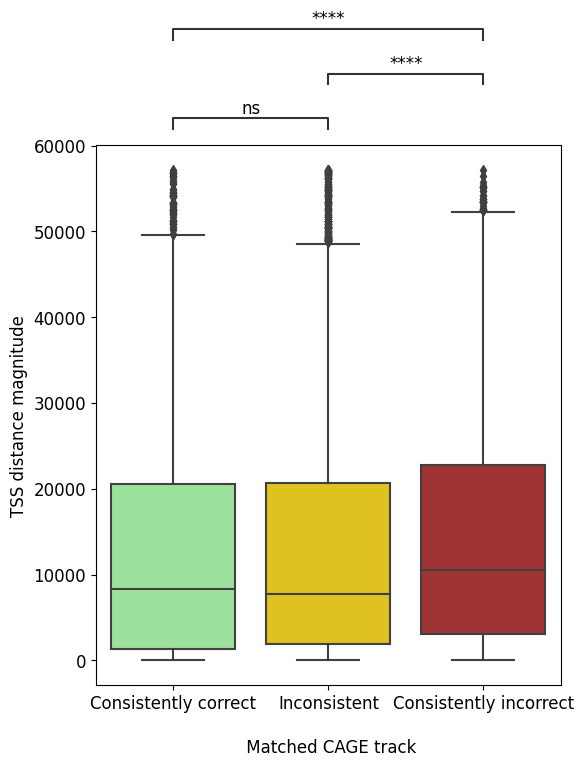

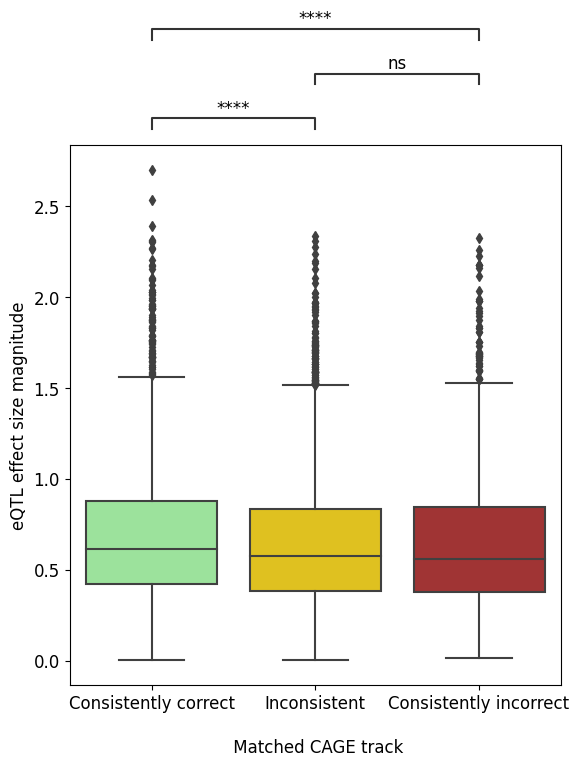

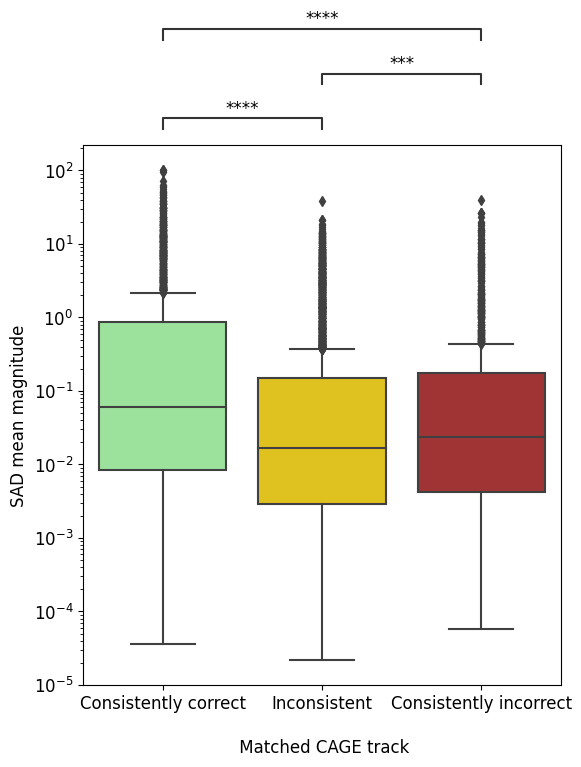

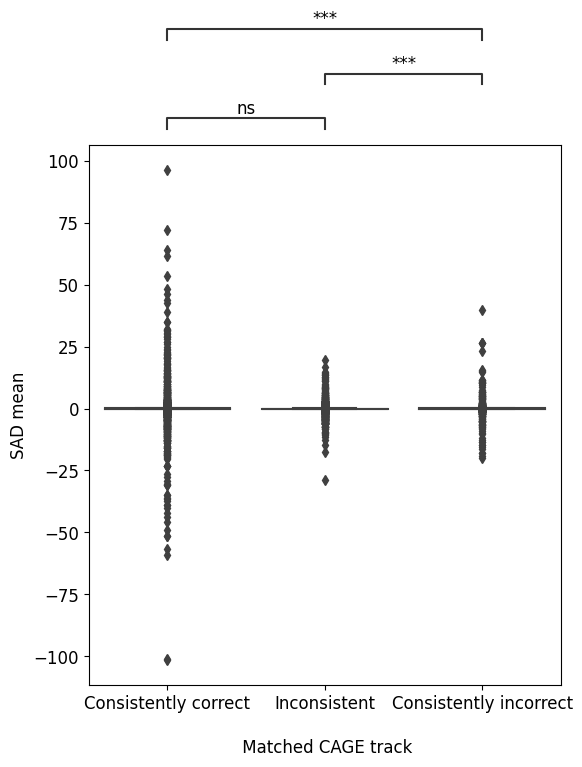

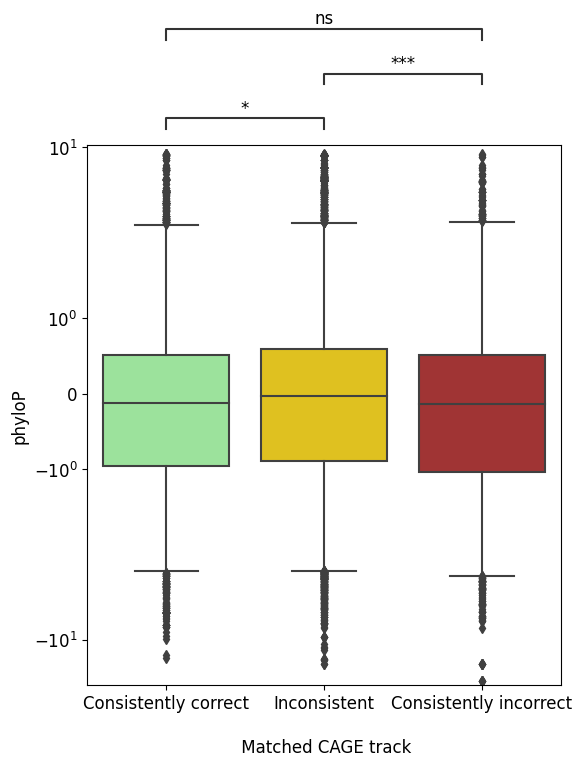

In [26]:
# Plots with significance for combined tissues df (pos set only)
pairs=[("Consistently correct", "Consistently incorrect"), 
       ("Consistently correct", "Inconsistent"), 
       ("Consistently incorrect", "Inconsistent")]
order=["Consistently correct", "Inconsistent", "Consistently incorrect"]
colors = ['lightgreen', 'gold', 'firebrick']
plt.rcParams.update({'font.size': 12})

x="sign agreement"
for y in ["TSS distance magnitude", "eQTL effect size magnitude", "SAD mean magnitude", "SAD mean", "phyloP"]:
    #fig, ax = plt.subplots(figsize=(5.5,4))
    fig, ax = plt.subplots(figsize=(6,8))
    ax = sns.boxplot(data=all_tissue_df, x=x,  y=y, ax=ax, order=order, palette=colors)
    
    if y == "phyloP":
        plt.yscale('symlog')
    if y == "SAD mean magnitude":
        plt.yscale('log')

    annotator = Annotator(ax, pairs, data=all_tissue_df, x=x, y=y)
    annotator.configure(test='Mann-Whitney', text_format='star', loc='outside')
    annotator.apply_and_annotate()

    #plt.suptitle(f"Sign agreement vs. {y} \n for {assay_name} prediction for all tissues")
    plt.xlabel(f'\n Matched {assay_name} track')
    plt.tight_layout()
    y_name = y.replace(' ', '_')
    plt.savefig(f"{SAVE_PATH}/{assay_name}/all_tissues_{assay_name}_sign_good_bad_noise_{y_name}.pdf", dpi=300)

## comparing majority vote sign with replicate 1 sign

In [27]:
num_samples = 100
bootstrapped_direction_predictions = pd.DataFrame([])
distance_bins = [(0, 1000), (1000, 10_000), (10_000, 30_000), (30_000, np.inf)]
   
for tissue in tlist_sorted_pos:
    df = df_results_eqtls[tissue]["pos"]
    num_rows = df.shape[0]
    
    for bin_start, bin_end in distance_bins:
        bin_inds = df[(df["TSS distance magnitude"] >= bin_start) & (df["TSS distance magnitude"] < bin_end)].index.values
        
        for rep in range(num_samples):
        
            # create set of bootstrap data for current bin and current rep
            df_sampled = df.loc[bin_inds].sample(frac=1, replace=True)

            # evaluate on ensemble majority vote
            direction_labels = (df_sampled["eQTL direction"] > 0).values
            acc = accuracy_score(direction_labels, df_sampled["SAD sign majority vote"] > 0)
            bootstrapped_direction_predictions = bootstrapped_direction_predictions.append(
                {"Tissue": tissue,
                 "Model": "ensemble majority vote",
                 "Bin": f"{bin_start}-{bin_end}",
                 "Accuracy": acc,
                 "Sample": rep},
                ignore_index=True)

            # evaluate on replicate 1
            direction_labels = (df_sampled["eQTL direction"] > 0).values
            acc = accuracy_score(direction_labels, df_sampled["SAD sign replicate 1"] > 0)
            bootstrapped_direction_predictions = bootstrapped_direction_predictions.append(
                {"Tissue": tissue,
                 "Model": "replicate 1",
                 "Bin": f"{bin_start}-{bin_end}",
                 "Accuracy": acc,
                 "Sample": rep},
                ignore_index=True)
            

/clusterfs/nilah/ayesha/envs/plotting_py37/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  if sys.path[0] == "":


<Figure size 800x600 with 0 Axes>

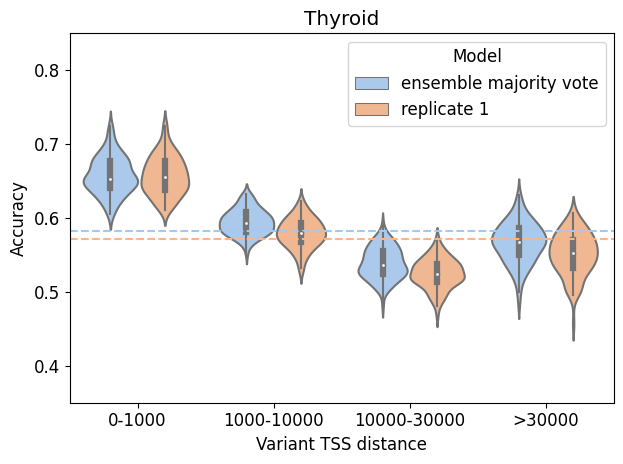

<Figure size 800x600 with 0 Axes>

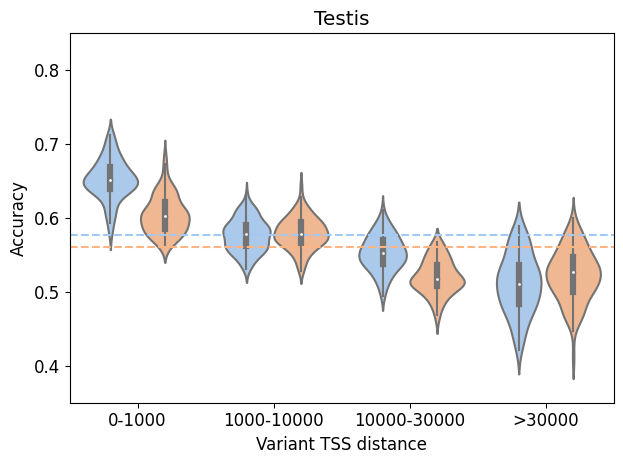

<Figure size 800x600 with 0 Axes>

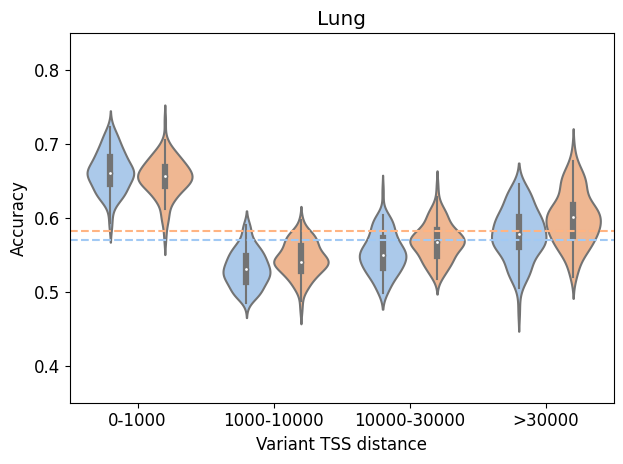

<Figure size 800x600 with 0 Axes>

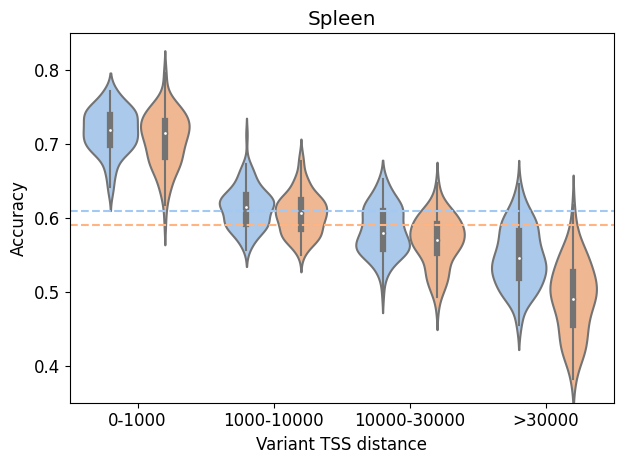

<Figure size 800x600 with 0 Axes>

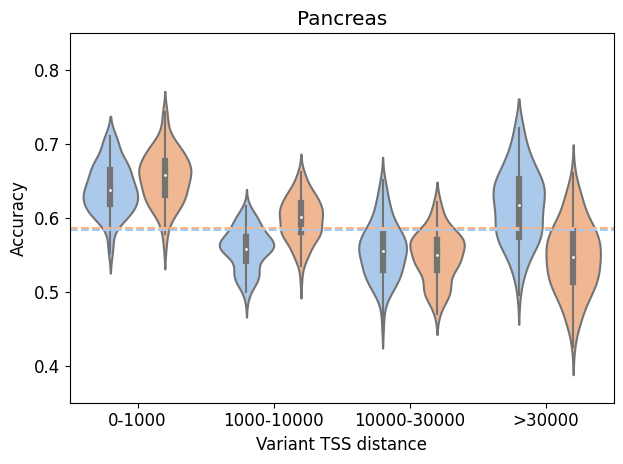

<Figure size 800x600 with 0 Axes>

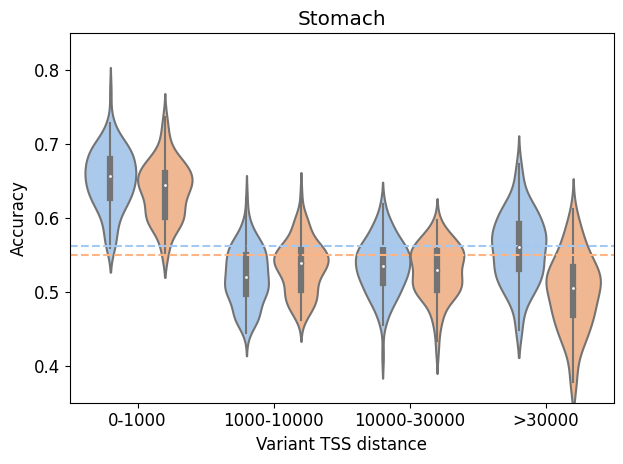

<Figure size 800x600 with 0 Axes>

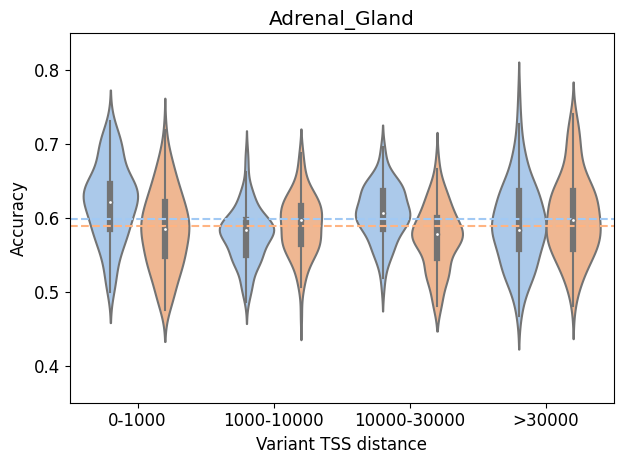

<Figure size 800x600 with 0 Axes>

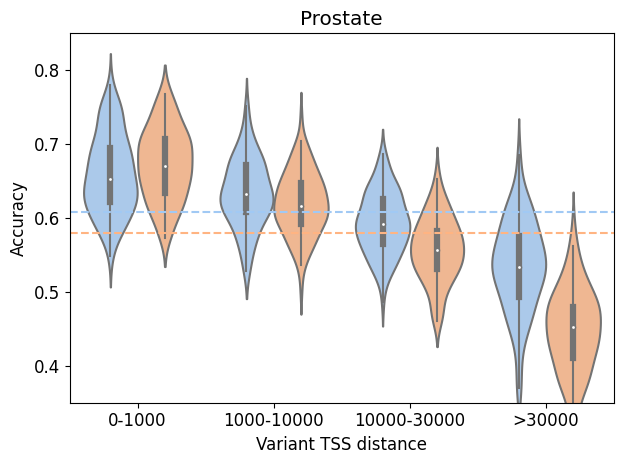

<Figure size 800x600 with 0 Axes>

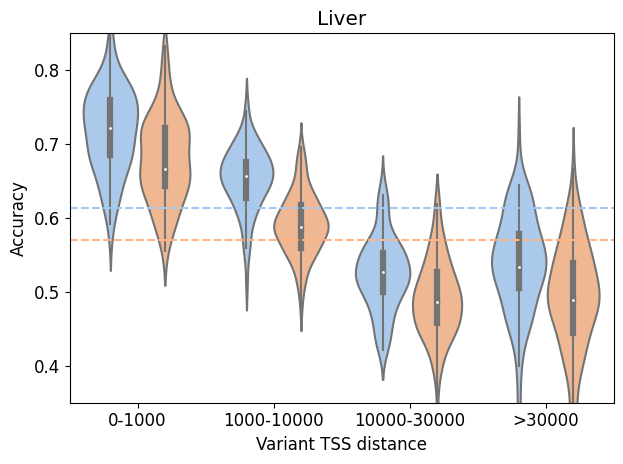

<Figure size 800x600 with 0 Axes>

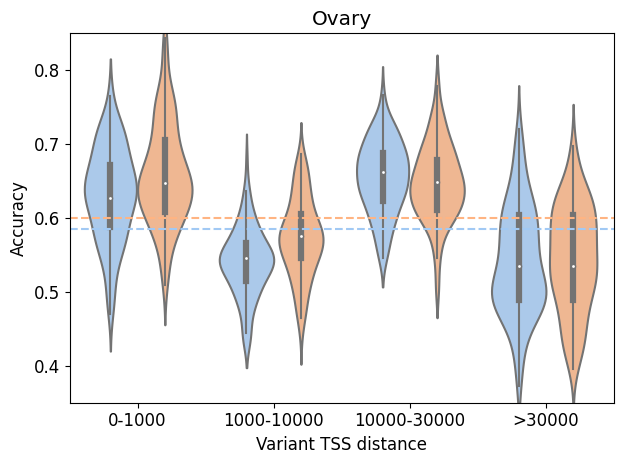

<Figure size 800x600 with 0 Axes>

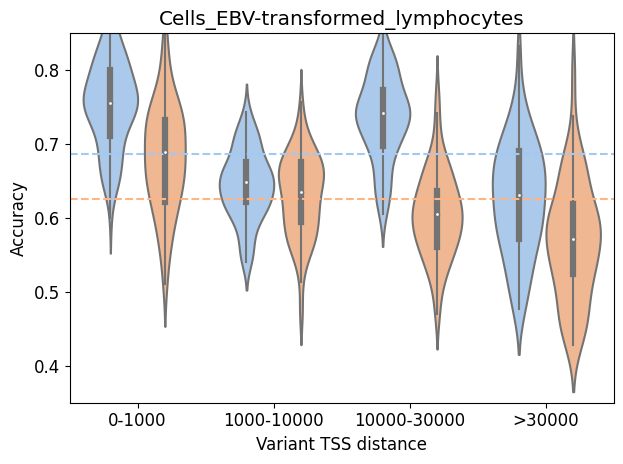

<Figure size 800x600 with 0 Axes>

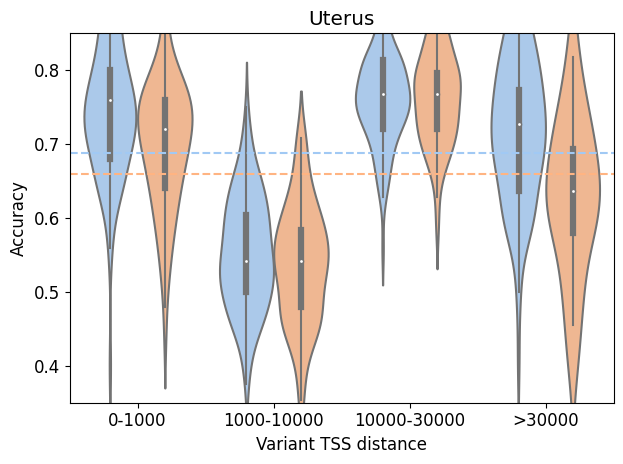

<Figure size 800x600 with 0 Axes>

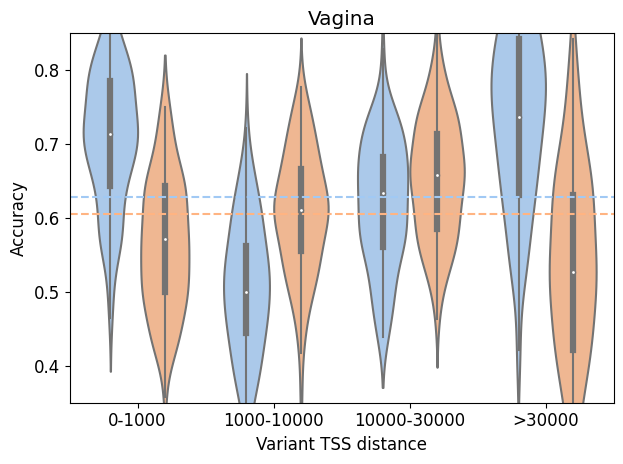

In [28]:
# violin plots using bootstrapped data

sns.set_palette('pastel')
plt.rcParams.update({'font.size': 12})

ensemble_accs, rep1_accs = [], []

for tissue in tlist_sorted_pos:
    df = df_results_eqtls[tissue]["pos"]
    num_rows = df.shape[0]

    plt.figure(figsize=(8,6))
    
    # first plot a dashed line at the accuracies calculated for majority vote and for replicate 1
    maj_vote_acc = accuracy_score(df["eQTL direction"]>0, df['SAD sign majority vote']>0)
    ensemble_accs.append(maj_vote_acc)
    rep_1_acc = accuracy_score(df["eQTL direction"]>0, df['SAD sign replicate 1']>0)
    rep1_accs.append(rep_1_acc)

    fig, ax = plt.subplots()
    sns.violinplot(data=bootstrapped_direction_predictions[(bootstrapped_direction_predictions["Tissue"] == tissue)],
                   x="Bin", y="Accuracy", hue="Model")

    plt.ylim(0.35, 0.85)
    plt.xlim(-0.5, 3.5)
    plt.plot([-0.5, 3.5], [maj_vote_acc, maj_vote_acc], linestyle="--")
    plt.plot([-0.5, 3.5], [rep_1_acc, rep_1_acc], linestyle="--")
    
    
    plt.xticks(np.arange(4), ["0-1000", '1000-10000', '10000-30000', '>30000'])
    plt.xlabel("Variant TSS distance")
    #plt.title(f"{assay_name} sign prediction accuracy\nfor finemapped GTEx {tissue} eQTLs")
    #plt.title(f"{tissue}, {assay_name}")
    plt.title(f"{tissue}")
    plt.tight_layout()
    if tissue != "Thyroid":
        plt.legend('',frameon=False)
        #ax.get_legend().remove()
    
    plt.savefig(f'{SAVE_PATH}/{assay_name}/sign_accuracy_TSS_bins_{assay_name}_{tissue}.pdf')

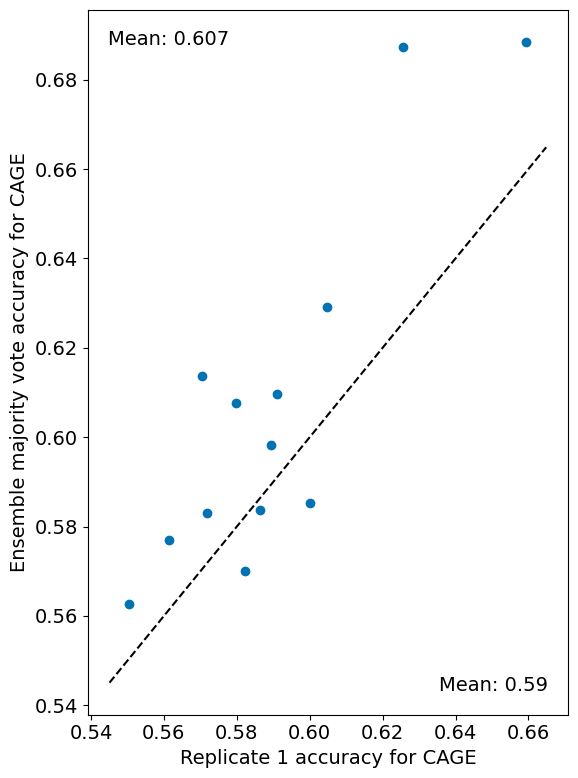

In [29]:
# scatterplot of majority vote vs. single replicate accuracy

labels = list(tlist_sorted_pos).copy()
labels[6] = "Adrenal Gland"
labels[10] = "Cells \n (EBV-transformed lymphocytes)"

sns.set_palette('colorblind')
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(6,8))

ax.scatter(rep1_accs, ensemble_accs, )
xpoints = ypoints = ax.get_xlim()
ax.plot(xpoints, ypoints, color='black', linestyle="--")

ax.annotate(f'Mean: {np.mean(rep1_accs).round(3)}',
            xy=(1, 0), xycoords='axes fraction',
            xytext=(-20, 20), textcoords='offset pixels',
            horizontalalignment='right',
            verticalalignment='bottom')
ax.annotate(f'Mean: {np.mean(ensemble_accs).round(3)}',
            xy=(0, 1), xycoords='axes fraction',
            xytext=(20, -20), textcoords='offset pixels',
            horizontalalignment='left',
            verticalalignment='top')

plt.xlabel(f"Replicate 1 accuracy for {assay_name}")
plt.ylabel(f"Ensemble majority vote accuracy for {assay_name}")
plt.tight_layout()
plt.savefig(f'{SAVE_PATH}/{assay_name}/sign_accuracy_{assay_name}_all_tissues.pdf')